In [1]:
# This notebook is taking from https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch/blob/main/demo.py
# for image dataloading samples

In [2]:
from video_dataset import  VideoFrameDataset, ImglistToTensor
from demo_model import FullModel
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from pathlib import Path
import json
from tensorboardX import SummaryWriter

In [3]:
writer = SummaryWriter()

In [4]:
def plot_video(rows, cols, frame_list, plot_width, plot_height):
    fig = plt.figure(figsize=(plot_width, plot_height))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     )

    for index, (ax, im) in enumerate(zip(grid, frame_list)):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_title(index)
    plt.show()

In [5]:
videos_root = Path("D:/__School/__Masters/____2021fALL/5280_aiwearables/combined_1st_2nd_iter_frames")
annotation_file = os.path.join(str(videos_root), 'annotations.txt')

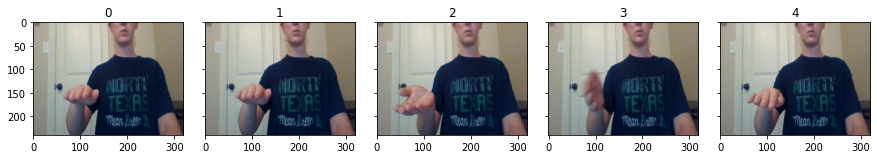

In [6]:
""" DEMO 1 WITHOUT IMAGE TRANSFORMS """
dataset = VideoFrameDataset(
        root_path=videos_root,
        annotationfile_path=annotation_file,
        num_segments=5,
        frames_per_segment=1,
        imagefile_template='img_{:05d}.jpg',
        transform=None,
        random_shift=True,
        test_mode=False
    )

sample = dataset[0]
frames = sample[0]  # list of PIL images
label = sample[1]   # integer label

plot_video(rows=1, cols=5, frame_list=frames, plot_width=15., plot_height=3.)

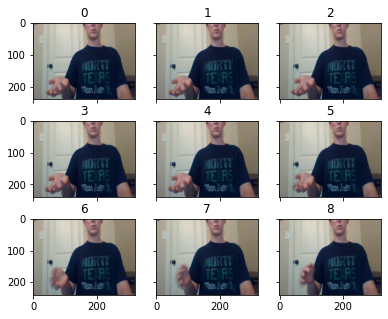

In [7]:
""" DEMO 2 SINGLE CONTINUOUS FRAME CLIP INSTEAD OF SAMPLED FRAMES, WITHOUT TRANSFORMS """
# If you do not want to use sparse temporal sampling, and instead
# want to just load N consecutive frames starting from a random
# start index, this is easy. Simply set NUM_SEGMENTS=1 and
# FRAMES_PER_SEGMENT=N. Each time a sample is loaded, N
# frames will be loaded from a new random start index.
dataset = VideoFrameDataset(
    root_path=videos_root,
    annotationfile_path=annotation_file,
    num_segments=1,
    frames_per_segment=9,
    imagefile_template='img_{:05d}.jpg',
    transform=None,
    random_shift=True,
    test_mode=False
)

sample = dataset[3]
frames = sample[0]  # list of PIL images
label = sample[1]  # integer label

plot_video(rows=3, cols=3, frame_list=frames, plot_width=10., plot_height=5.)

Video Tensor Size: torch.Size([8, 3, 96, 96])


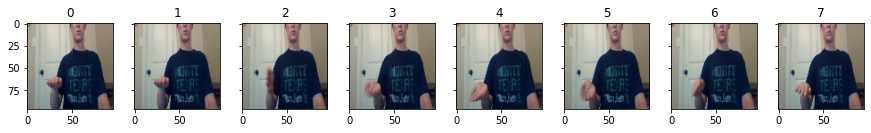

In [37]:
 """ DEMO 3 WITH TRANSFORMS """
# As of torchvision 0.8.0, torchvision transforms support batches of images
# of size (BATCH x CHANNELS x HEIGHT x WIDTH) and apply deterministic or random
# transformations on the batch identically on all images of the batch. Any torchvision
# transform for image augmentation can thus also be used  for video augmentation.
preprocess = transforms.Compose([
    ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    transforms.Resize((96, 96)),  # image batch, resize to 100x160
    #transforms.CenterCrop(96),  # image batch, center crop to square 96x96
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = VideoFrameDataset(
    root_path=videos_root,
    annotationfile_path=annotation_file,
    num_segments=8,
    frames_per_segment=1,
    imagefile_template='img_{:05d}.jpg',
    transform=preprocess,
    random_shift=True,
    test_mode=False
)

sample = dataset[2]
frame_tensor = sample[0]  # tensor of shape (NUM_SEGMENTS*FRAMES_PER_SEGMENT) x CHANNELS x HEIGHT x WIDTH
label = sample[1]  # integer label

print('Video Tensor Size:', frame_tensor.size())

def denormalize(video_tensor):
    """
    Undoes mean/standard deviation normalization, zero to one scaling,
    and channel rearrangement for a batch of images.
    args:
        video_tensor: a (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
    """
    inverse_normalize = transforms.Normalize(
        mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
        std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
    )
    return (inverse_normalize(video_tensor) * 255.).type(torch.uint8).permute(0, 2, 3, 1).numpy()


frame_tensor = denormalize(frame_tensor)
plot_video(rows=1, cols=8, frame_list=frame_tensor, plot_width=15., plot_height=3.)

In [38]:
""" DEMO 3 CONTINUED: DATALOADER """
train_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

In [39]:
"""for epoch in range(10):
    for video_batch, labels in dataloader:

        # Insert Training Code Here
        
        print(labels)
        print("\nVideo Batch Tensor Size:", video_batch.size())
        print("Batch Labels Size:", labels.size())
        break
    break
"""

'for epoch in range(10):\n    for video_batch, labels in dataloader:\n\n        # Insert Training Code Here\n        \n        print(labels)\n        print("\nVideo Batch Tensor Size:", video_batch.size())\n        print("Batch Labels Size:", labels.size())\n        break\n    break\n'

In [40]:
batch_size = 1
steps_before_print = 1000
num_workers = 1
step_size = 2
num_frames = 32 // step_size

In [41]:
model = FullModel(batch_size=batch_size)

In [42]:
if torch.cuda.is_available():
    print('Cuda is available!')
    model.cuda()

Cuda is available!


In [43]:
def save_model(model, use_ts=False):
    if use_ts:
        time_stamp = time.strftime("%d_%b_%Y_%Hh%Mm", time.gmtime())
        torch.save(model.state_dict(), curr_folder + '/{}.ckp'.format(time_stamp))
    else:
        torch.save(model.state_dict(), curr_folder + '/{}.ckp'.format('best_model'))

In [44]:
def train(epochs):
    
    print("Training is about to start...")
    best_validation_loss = model.best_validation_loss

    for epoch in range(epochs):
        step = 0
        epoch_loss = 0
        epoch_acc = 0
        times_calculated = 0
        total_size = len(train_loader)
        for i, (images, labels) in enumerate(train_loader):
            model.train()

            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            writer.add_scalar('training_loss', loss.item(), model.steps)
            loss.backward()
            optimizer.step()

            step += 1
            epoch_loss += loss.item()
            """
            if step % steps_before_print == 0:
                # Calculate Accuracy
                model.eval()
                validation_loss, accuracy = utils.calculate_loss_and_accuracy(validation_loader, model, criterion, stop_at = 1200)
                writer.add_scalar('validation_loss', validation_loss, model.steps)
                writer.add_scalar('accuracy', accuracy, model.steps)
                epoch_acc += accuracy
                times_calculated += 1
                # Print Loss
                print('Iteration: {}/{} - ({:.2f}%). Loss: {}. Accuracy: {}'.format(step, total_size, step*100/total_size , loss.item(), accuracy))
                if validation_loss < model.best_validation_loss:
                    model.best_valdiation_loss = validation_loss
                    print('Saving best model')
                    save_model(model)
                del validation_loss
            del loss, outputs, images, labels
            """

        model.epochs += 1

        #print('Epoch({}) avg loss: {} avg acc: {}'.format(epoch, epoch_loss/step, epoch_acc/times_calculated))
        print('Epoch ', epoch)
        #save_model(model, use_ts=True)

In [45]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [46]:
# https://github.com/ultralytics/yolov3/issues/1643
# https://stackoverflow.com/questions/64837376/how-to-efficiently-run-multiple-pytorch-processes-models-at-once-traceback
# paging file issues solved by reducing dataloader workers to 1
train(10)
# save_model(model, use_ts=True)

Training is about to start...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2304 and 4608x2304)